In [1]:
from tqdm import tqdm
import csv
import sys
csv.field_size_limit(sys.maxsize)
import re
import itertools

In [2]:
file="Data/author_contribution_full.csv"

In [3]:
sec2label = {
    'introduction': 'Introduction',
    # 'background': 'Background',
    'related work': 'Related Work',
    'related works': 'Related Work',
    'preliminary': 'Preliminaries',
    'preliminaries': 'Preliminaries',
    'experiment': 'Experiments',
    'experiments': 'Experiments',
    'numerical experiments': 'Experiments',
    'methods': 'Methods',
    'methodology': 'Methods',
    'method': 'Methods',
    'model': 'Methods',
    'the model': 'Methods',
    'proposed method': 'Methods',
    'proofs': 'Methods',
    'notation': 'Methods',
    # 'examples': 'Examples',
    # 'observations': 'Observations'
    'results': 'Results',
    'main results': 'Results',
    'numerical results': 'Results',
    # 'simulation': 'Simulation',
    # 'evaluation': 'Evaluation',
    # 'applications': 'Applications',
    # 'summary': 'Summary',
    'conclusion': 'Conclusions',
    'conclusions': 'Conclusions',
    'concluding remarks': 'Conclusions',
    'final remarks': 'Conclusions',
    'discussion': 'Discussion',
    'discussions': 'Discussion',
    # 'acknowledgements': 'Acknowledgements',
    # 'acknowledgement': 'Acknowledgements',
    # 'acknowledgments': 'Acknowledgements',
    # 'acknowledgment': 'Acknowledgements',
    # 'appendix': 'Appendix', 
    # 'appendixes': 'Appendix', 
    # 'appendices': 'Appendix', 
}

In [4]:
secList=["Introduction","Preliminaries","Related Work","Experiments","Methods","Results","Conclusions","Discussion"]
D1=dict({i:0 for i in secList}) # Number of authors contributing to each section
D1_=dict({i:0 for i in secList}) # Number of times each section appears in paper-author units
D2=dict({i:0 for i in list(itertools.combinations(secList,2))}) # Number of authors contributing to each section pair
D2_=dict({i:0 for i in list(itertools.combinations(secList,2))}) # Number of times each section pair appears in paper-author units
D3=dict({i:{j:0 for j in secList if j!=i} for i in secList}) # Conditional count of authors contributing to one section given contribution to another
paper_num=0
unit_num=0
year_l=[]

with open(file,mode="r",encoding="utf-8") as FI:
     
     reader=csv.reader(FI)
     cols=next(reader)
     
     for row in tqdm(reader):
          
          # Map author IDs
          pid=row[cols.index("arxiv_id")]
          dic=eval(re.sub(r"defaultdict\(<class 'int'>, (\{.*?\})\)", r"\1", row[cols.index('author_section_contribution')]))
          if len(dic)<2:
               continue
          year_l.append(row[cols.index("pub_year_from_open_alex")])

          # Map sections
          total={}
          details={}
          for aid in dic:
               details[aid]={}
               for sec in dic[aid]:
                    sec_=sec.strip().lower().replace("\label{","").replace("sec:","").replace("\t","")
                    for s in sec_.split("and"):
                         if s in sec2label:
                              details[aid][sec2label[s]]=dic[aid][sec]
               total.update(details[aid])
          if len(total)<2: # Keep only papers with at least two valid sections
               continue
          if 0 in total.values(): # Keep only papers with non-zero contributions in all sections
               continue

          paper_num+=1
          unit_num+=len(dic)
          for aname in details:
               # Cooccurence
               l=[sec for sec in details[aname] if details[aname][sec]!=0]
               for sec in l:
                    D1[sec]+=1
               for pair in D2:
                    if pair[0] in l and pair[1] in l:
                         D2[pair]+=1
               # Total units
               l_=[sec for sec in secList if sec in total]
               for sec in l_:
                    D1_[sec]+=1
               for pair in list(itertools.combinations(l_,2)):
                    D2_[pair]+=1
               # Single sections in cooccurence papers
               for sec1 in D3:
                    for sec2 in D3:
                         if sec1==sec2:
                              continue
                         if sec1 in l_ and sec2 in l_ and sec1 in l:
                              D3[sec1][sec2]+=1

0it [00:00, ?it/s]

2840569it [07:15, 6529.00it/s]


In [5]:
print(paper_num,unit_num)

61982 351780


In [6]:
print(min(year_l),max(year_l))

 2024


# Co-occurence frequency

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

In [9]:
sections = ['Introduction', 'Preliminaries', 'Methods', 'Results', 'Conclusions', 'Discussion']

In [10]:
edges = {pair: D2[pair] / D2_[pair] for pair in D2 if "Related Work" not in pair and "Experiments" not in pair}
edges

{('Introduction', 'Preliminaries'): 0.7444790202770528,
 ('Introduction', 'Methods'): 0.7283334435116018,
 ('Introduction', 'Results'): 0.7342585066779053,
 ('Introduction', 'Conclusions'): 0.6829502644697287,
 ('Introduction', 'Discussion'): 0.6173844537815126,
 ('Preliminaries', 'Methods'): 0.7831325301204819,
 ('Preliminaries', 'Results'): 0.7778402699662542,
 ('Preliminaries', 'Conclusions'): 0.7259243336199485,
 ('Preliminaries', 'Discussion'): 0.744433688286544,
 ('Methods', 'Results'): 0.7324933095450491,
 ('Methods', 'Conclusions'): 0.710904911892398,
 ('Methods', 'Discussion'): 0.688616311598881,
 ('Results', 'Conclusions'): 0.7080311222471317,
 ('Results', 'Discussion'): 0.6202472318237741,
 ('Conclusions', 'Discussion'): 0.5890831162282545}

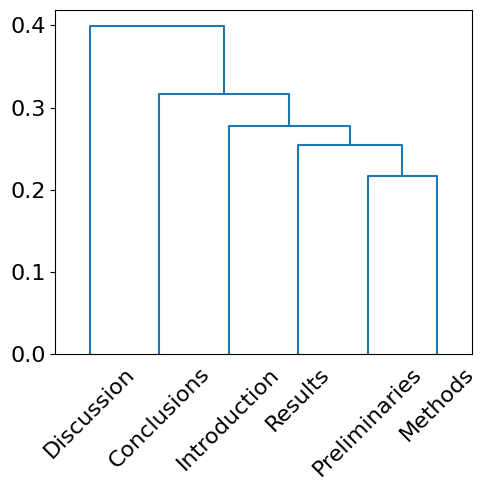

In [16]:
# Initialize similarity matrix
similarity = np.ones((6, 6))

# Fill in similarity matrix using computed edge weights
for (a, b), sim in edges.items():
    i, j = sections.index(a), sections.index(b)
    similarity[i][j] = sim
    similarity[j][i] = sim
# Convert similarity matrix to distance matrix (must be in condensed form)
distance = 1 - similarity
condensed_distance = squareform(distance)  # Extract upper triangle for clustering

# Perform hierarchical clustering using "ward" linkage
Z = linkage(condensed_distance, method='ward')

# Plot dendrogram
plt.figure(figsize=(5,5))
dendrogram(Z, labels=sections, leaf_rotation=45, leaf_font_size=16, color_threshold=0)
plt.yticks([y/10 for y in range(0,5)],size=16)
plt.tight_layout()
plt.savefig("Figures/Figure 2B_Hierarchical Clustering Dendrogram of Sections.pdf")
plt.show()

# Conditional Probability

In [17]:
target=['Introduction', 'Preliminaries', 'Methods', 'Results', 'Conclusions', 'Discussion']

In [18]:
P_single={}
for i in target:
    P_single[i]={}
    for j in target:
        if j==i:
            continue
        try:
            P_single[i][j]=D3[i][j]/D2_[(i,j)]
        except:
            P_single[i][j]=D3[i][j]/D2_[(j,i)]
P_single

{'Introduction': {'Preliminaries': 0.7589339490062237,
  'Methods': 0.7396377338533747,
  'Results': 0.7484873114783708,
  'Conclusions': 0.7019721070055939,
  'Discussion': 0.6358849789915967},
 'Preliminaries': {'Introduction': 0.7601385264003212,
  'Methods': 0.7961847389558233,
  'Results': 0.7913385826771654,
  'Conclusions': 0.7609630266552021,
  'Discussion': 0.7705711519845111},
 'Methods': {'Introduction': 0.7438024724003438,
  'Preliminaries': 0.7911646586345381,
  'Results': 0.7423059768064229,
  'Conclusions': 0.7388269345364774,
  'Discussion': 0.7075532601678503},
 'Results': {'Introduction': 0.7469721143522281,
  'Preliminaries': 0.7941507311586051,
  'Methods': 0.7467662801070473,
  'Conclusions': 0.7240933667413952,
  'Discussion': 0.6375886109320992},
 'Conclusions': {'Introduction': 0.695127287948552,
  'Preliminaries': 0.7368873602751504,
  'Methods': 0.718992083085043,
  'Results': 0.7210075168139259,
  'Discussion': 0.6094629800823599},
 'Discussion': {'Introducti

In [19]:
P_pair={pair: D2[pair]/D2_[pair] for pair in D2 if pair[0] in target and pair[1] in target}
P_pair

{('Introduction', 'Preliminaries'): 0.7444790202770528,
 ('Introduction', 'Methods'): 0.7283334435116018,
 ('Introduction', 'Results'): 0.7342585066779053,
 ('Introduction', 'Conclusions'): 0.6829502644697287,
 ('Introduction', 'Discussion'): 0.6173844537815126,
 ('Preliminaries', 'Methods'): 0.7831325301204819,
 ('Preliminaries', 'Results'): 0.7778402699662542,
 ('Preliminaries', 'Conclusions'): 0.7259243336199485,
 ('Preliminaries', 'Discussion'): 0.744433688286544,
 ('Methods', 'Results'): 0.7324933095450491,
 ('Methods', 'Conclusions'): 0.710904911892398,
 ('Methods', 'Discussion'): 0.688616311598881,
 ('Results', 'Conclusions'): 0.7080311222471317,
 ('Results', 'Discussion'): 0.6202472318237741,
 ('Conclusions', 'Discussion'): 0.5890831162282545}

In [20]:
P_conditional={}
for (A,B),joint_prob in P_pair.items():
    P_conditional["|".join([A,B])]=joint_prob/P_single[B][A]
    P_conditional["|".join([B,A])]=joint_prob/P_single[A][B]

In [21]:
sorted(P_conditional.items(),key=lambda x: x[1],reverse=True)

[('Preliminaries|Methods', 0.9898477157360406),
 ('Methods|Conclusions', 0.9887520719867392),
 ('Results|Methods', 0.9867808322066998),
 ('Methods|Discussion', 0.986740672217083),
 ('Preliminaries|Conclusions', 0.9851225204200701),
 ('Methods|Introduction', 0.9847164499262636),
 ('Methods|Preliminaries', 0.9836065573770492),
 ('Introduction|Results', 0.9829798095135747),
 ('Results|Preliminaries', 0.9829424307036246),
 ('Introduction|Conclusions', 0.9824823112400609),
 ('Results|Conclusions', 0.9820024143102754),
 ('Results|Introduction', 0.9809899184899186),
 ('Preliminaries|Introduction', 0.9809536406322333),
 ('Methods|Results', 0.9808869643123788),
 ('Preliminaries|Discussion', 0.9796178343949044),
 ('Preliminaries|Results', 0.9794617563739377),
 ('Introduction|Preliminaries', 0.9793991416309014),
 ('Introduction|Methods', 0.9792027729636048),
 ('Results|Discussion', 0.9778331947908008),
 ('Conclusions|Results', 0.977817440081591),
 ('Introduction|Discussion', 0.9776484042000209),


In [22]:
# Make differences more visually noticeable
min_width = 0.5
max_width = 6
alpha = 15
def amplify_weight(w, min_w, max_w, alpha=15):
    return min_width + (max_width - min_width) * (np.exp(alpha * (w - min_w)) - 1) / (np.exp(alpha * (max_w - min_w)) - 1)

keyList=list(P_conditional.keys())
weights=P_conditional.values()
min_w, max_w = min(weights), max(weights)
edge_widths = [amplify_weight(w, min_w, max_w, alpha) for w in weights]
sorted({keyList[i]:round(edge_widths[i]*5,2) for i in range(len(keyList))}.items())

[('Conclusions|Discussion', 13.37),
 ('Conclusions|Introduction', 15.17),
 ('Conclusions|Methods', 7.58),
 ('Conclusions|Preliminaries', 2.5),
 ('Conclusions|Results', 19.09),
 ('Discussion|Conclusions', 10.53),
 ('Discussion|Introduction', 13.66),
 ('Discussion|Methods', 15.43),
 ('Discussion|Preliminaries', 10.19),
 ('Discussion|Results', 15.1),
 ('Introduction|Conclusions', 23.09),
 ('Introduction|Discussion', 18.95),
 ('Introduction|Methods', 20.25),
 ('Introduction|Preliminaries', 20.42),
 ('Introduction|Results', 23.53),
 ('Methods|Conclusions', 28.92),
 ('Methods|Discussion', 26.99),
 ('Methods|Introduction', 25.11),
 ('Methods|Preliminaries', 24.1),
 ('Methods|Results', 21.69),
 ('Preliminaries|Conclusions', 25.48),
 ('Preliminaries|Discussion', 20.6),
 ('Preliminaries|Introduction', 21.75),
 ('Preliminaries|Methods', 30.0),
 ('Preliminaries|Results', 20.47),
 ('Results|Conclusions', 22.67),
 ('Results|Discussion', 19.11),
 ('Results|Introduction', 21.78),
 ('Results|Methods', 